# Car and wireframe 3d visualization
code is borrowed from ["Augmented Reality"](https://www.kaggle.com/ebouteillon/augmented-reality)


In [28]:
import json
from math import sin, cos
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import cv2
from pathlib import Path

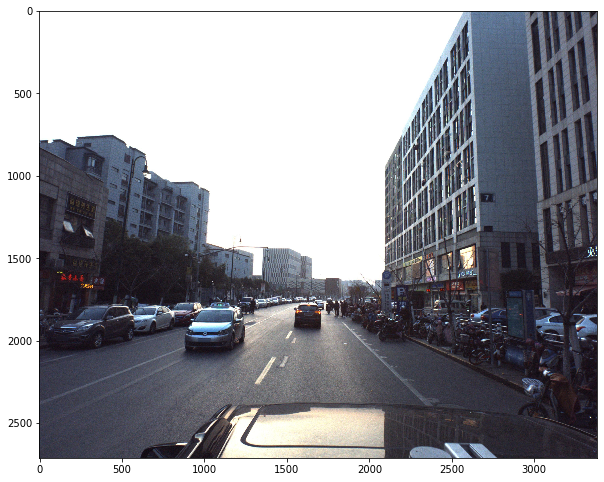

In [29]:
# Load an image
img_name = 'ID_0f128c40b'
img = cv2.imread(f'car-images/{img_name}.jpg' )
img = cv2.cvtColor(img ,cv2.COLOR_BGR2RGB )
plt.figure(figsize=(10,10))
plt.imshow( img );

In [30]:
train = pd.read_csv('train.csv')
pred_string = train[train.ImageId == img_name].PredictionString.iloc[0]
items = pred_string.split(' ')

アイテムのリストからモデル、ヨー、ピッチなどを組み分ける

In [31]:
model_types, yaws, pitches, rolls, xs, ys, zs = [items[i::7] for i in range(7)]

model_types = list( map(int , model_types) )

In [32]:
car_model_list = list( Path('models-json').rglob("*.json") )

In [33]:
# k is camera instrinsic matrix
k = np.array([[2304.5479, 0,  1686.2379],
           [0, 2305.8757, 1354.9849],
           [0, 0, 1]], dtype=np.float32)

# convert euler angle to rotation matrix
def euler_to_Rot(yaw, pitch, roll):
    Y = np.array([[cos(yaw), 0, sin(yaw)],
                  [0, 1, 0],
                  [-sin(yaw), 0, cos(yaw)]])
    P = np.array([[1, 0, 0],
                  [0, cos(pitch), -sin(pitch)],
                  [0, sin(pitch), cos(pitch)]])
    R = np.array([[cos(roll), -sin(roll), 0],
                  [sin(roll), cos(roll), 0],
                  [0, 0, 1]])
    return np.dot(Y, np.dot(P, R))

In [34]:
def draw_obj(image_n, vertices_n, triangles_n):
    for t in triangles_n:
        coord = np.array([vertices_n[t[0]][:2], vertices_n[t[1]][:2], vertices_n[t[2]][:2]], dtype=np.int32)
#         cv2.fillConvexPoly(image, coord, (0,0,255))
        cv2.polylines(image_n, np.int32([coord]), 1, (0,0,255))

In [36]:
overlay = np.zeros_like(img)
xxxx = zip( model_types , yaws, pitches, rolls, xs, ys, zs)

for model_type , yaw, pitch, roll, x, y, z in xxxx:
    yaw, pitch, roll, x, y, z = [float(x) for x in [yaw, pitch, roll, x, y, z]]
    
    # I think the pitch and yaw should be exchanged ??????
    yaw, pitch, roll = -pitch, -yaw, -roll
    Rt = np.eye(4)
    t = np.array([x, y, z])
    Rt[:3, 3] = t
    Rt[:3, :3] = euler_to_Rot(yaw, pitch, roll).T
    Rt = Rt[:3, :]
    
    with open( car_model_list[model_type] ) as json_file:
        data = json.load(json_file)
        
    vertices = np.array(data['vertices'])
    vertices[:, 1] = -vertices[:, 1]
    triangles = np.array(data['faces']) - 1
    
    P = np.ones((vertices.shape[0],vertices.shape[1]+1))
    P[:, :-1] = vertices
    P = P.T
    img_cor_points = np.dot(k, np.dot(Rt, P))
    img_cor_points = img_cor_points.T
    img_cor_points[:, 0] /= img_cor_points[:, 2]
    img_cor_points[:, 1] /= img_cor_points[:, 2]
    draw_obj(overlay, img_cor_points, triangles)
    


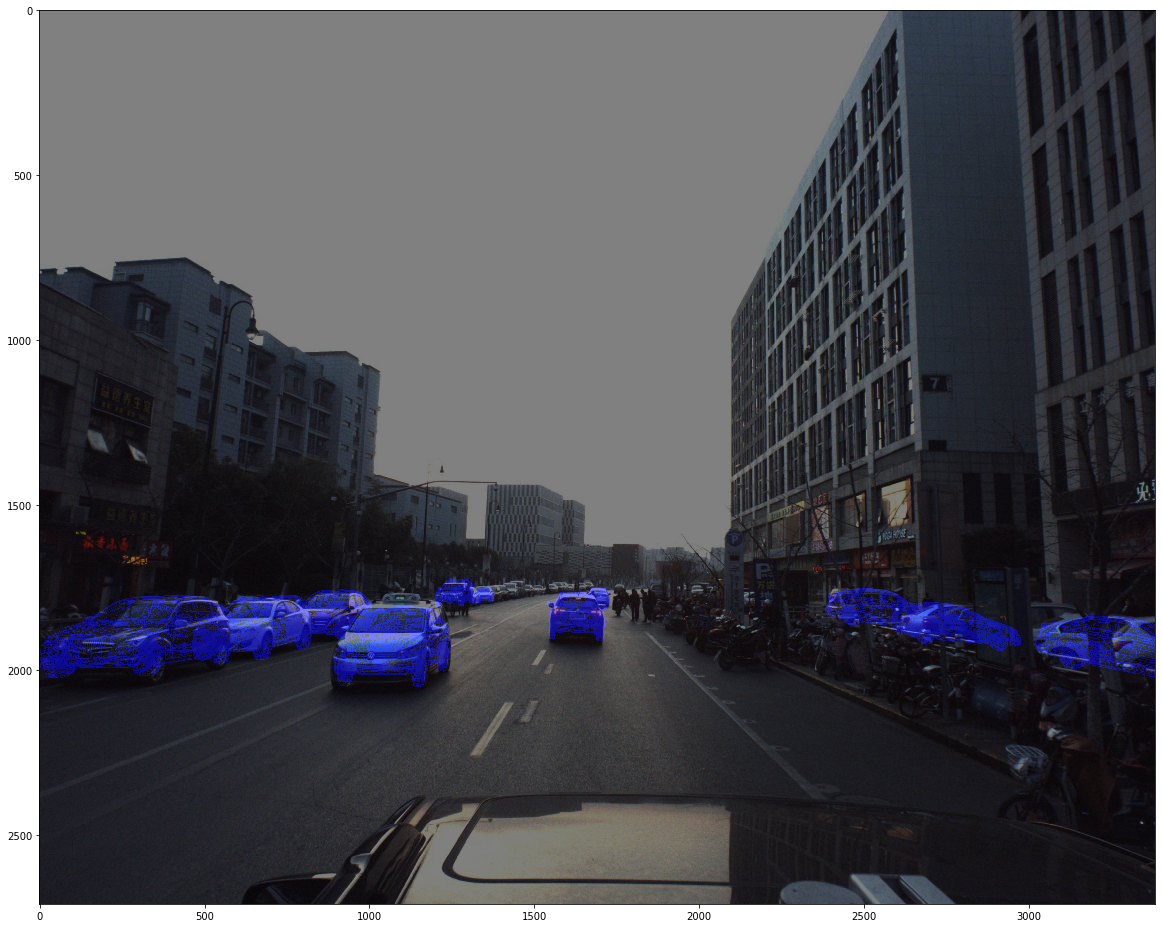

In [40]:
alpha = .5
img_n = np.array(img)
cv2.addWeighted(overlay, alpha, img_n, 1 - alpha, 0, img_n)
plt.figure(figsize=(20,20))
plt.imshow(img_n);